## History Kaggle Demo: Allstate Claims

You can get the detailed information and download the data from the following link:<br/>
https://www.kaggle.com/c/allstate-claims-severity

Note: You need to sign up a Kaggle Account before you can download the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time
import random
import math
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold,GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics, preprocessing

import xgboost as xgb
import seaborn as sns

from scipy import sparse
%matplotlib inline

## 1. load data

In [27]:
## Type your answers here ##
df_train = pd.read_csv("../train.csv")
df_test = pd.read_csv("../test.csv")

In [8]:
df_train.shape

(188318, 132)

In [9]:
df_test.shape

(125546, 131)

In [10]:
train_size = df_train.shape[0]

In [11]:
columns = list(df_train.columns)

In [12]:
df_train.cat100.unique()

array(['B', 'L', 'I', 'F', 'J', 'H', 'C', 'M', 'A', 'G', 'O', 'N', 'K',
       'D', 'E'], dtype=object)

In [13]:
(df_train.dtypes == 'object').sum()

116

In [14]:
df_train.head()

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,...,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,...,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,...,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,...,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,...,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85


In [15]:
full_data = pd.concat([df_train, df_test]).reset_index(drop=True)
del(df_train, df_test)
print ("Full Data set created.")

/Users/Jianhua/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


Full Data set created.


In [56]:
del(df_train, df_test)

In [16]:
data_types = full_data.dtypes

In [17]:
data_types.unique()

array([dtype('O'), dtype('float64'), dtype('int64')], dtype=object)

In [18]:
cat_cols = list(data_types[data_types == 'object'].index)
cont_cols = list(data_types[(data_types == 'int64') | (data_types == 'float64')].index)

In [19]:
id_col = 'id'
loss_col = 'loss'
cont_cols.remove(id_col)
cont_cols.remove(loss_col)

In [20]:
print ("Categorical features:", cat_cols)
print ( "Numerica features:", cont_cols)
print ( "ID: %s, target: %s" %( id_col, loss_col))

Categorical features: ['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat8', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat9', 'cat90', 'cat91

1. features are anonymous
2. features are all encoded
3. Not too many feature engineering things we can do, but still, you can try something:
e.g. new_feature1 = cont5 +-*/ cont6

**Some References:**<br/>
http://blog.kaggle.com/2017/02/27/allstate-claims-severity-competition-2nd-place-winners-interview-alexey-noskov/

## 2. Data visualization

/Users/Jianhua/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


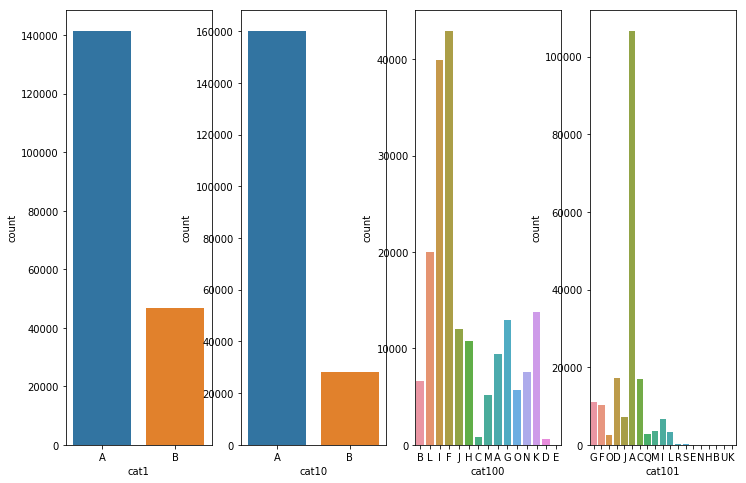

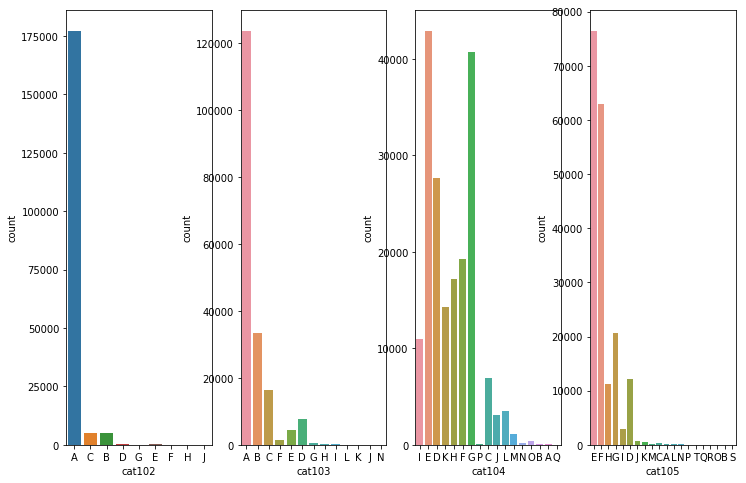

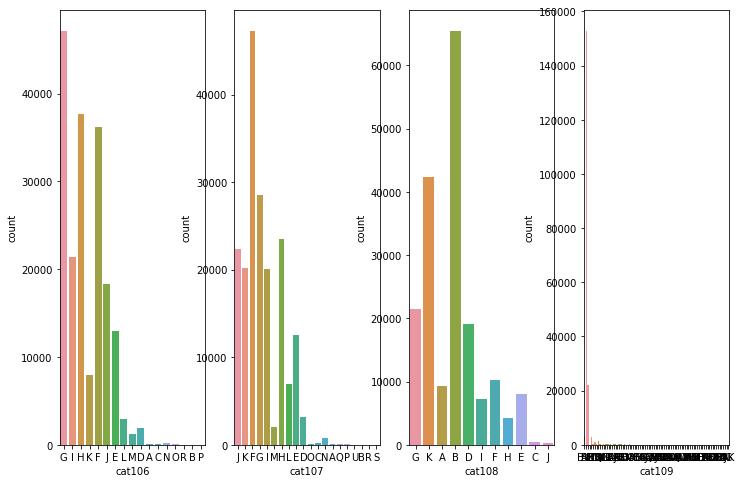

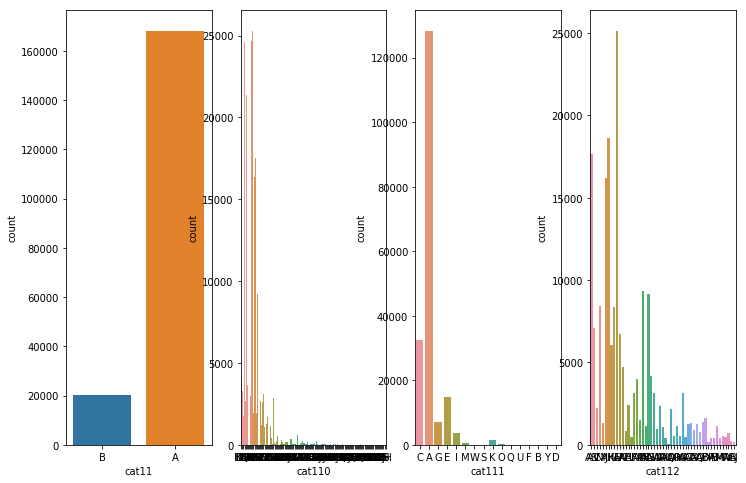

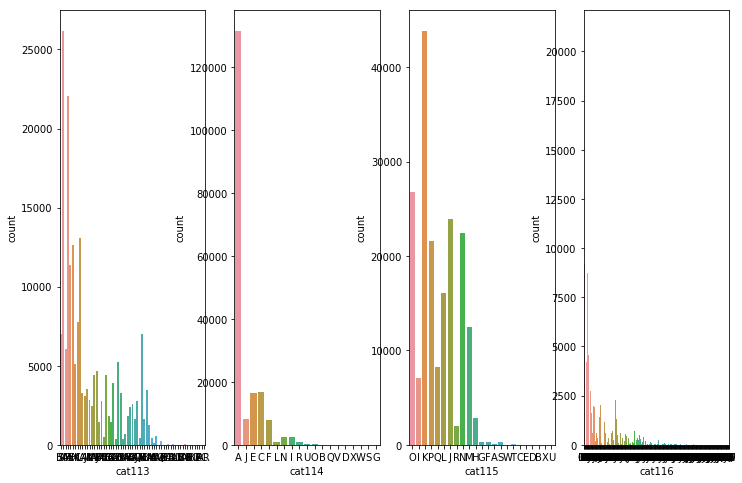

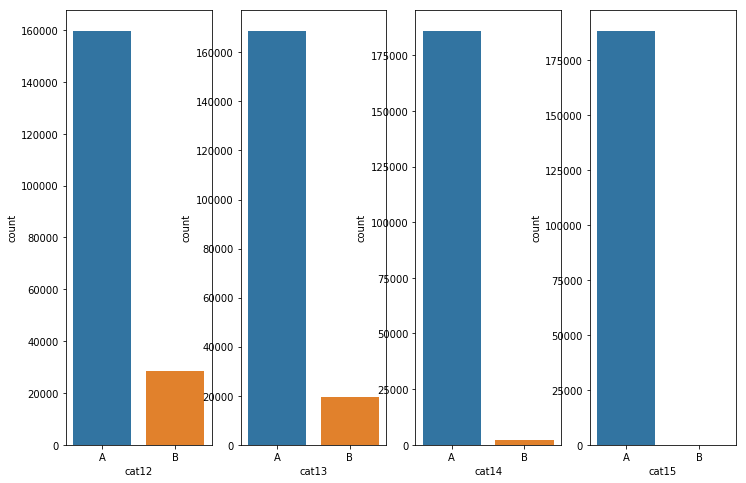

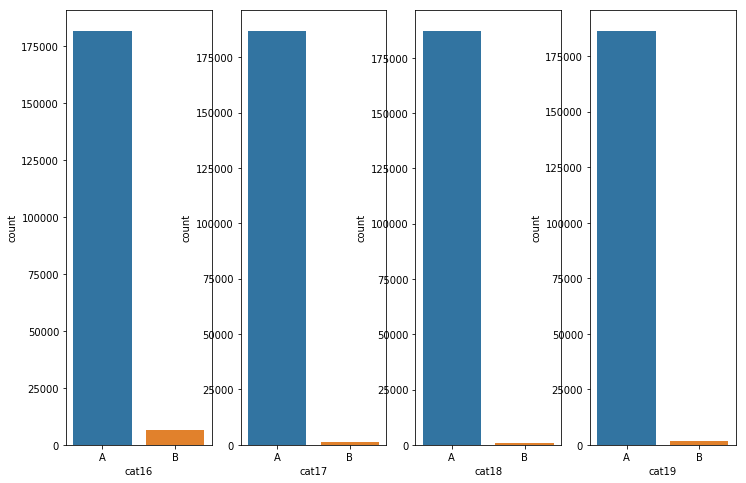

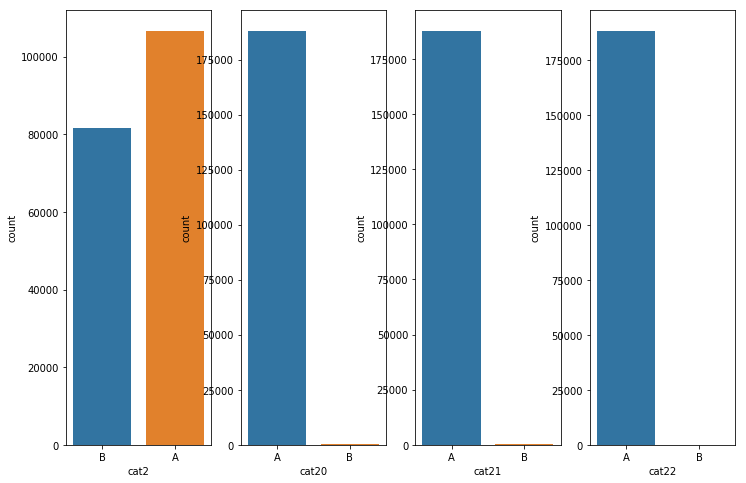

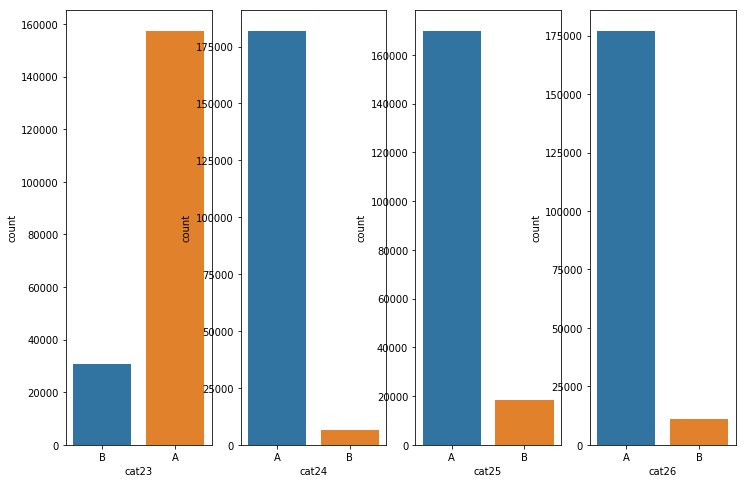

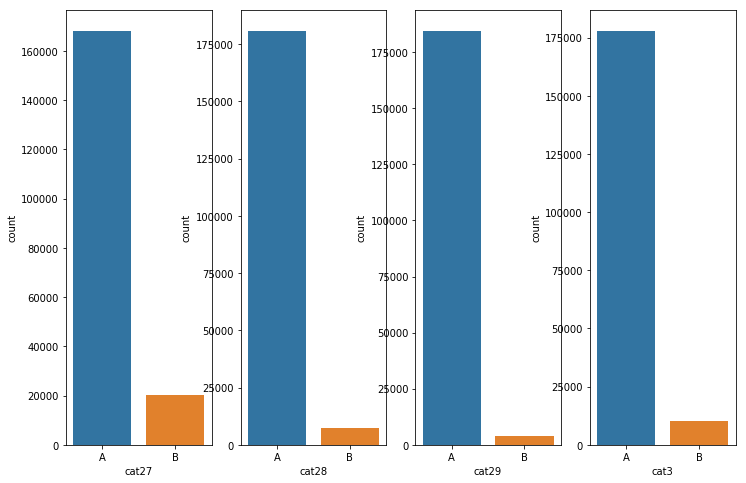

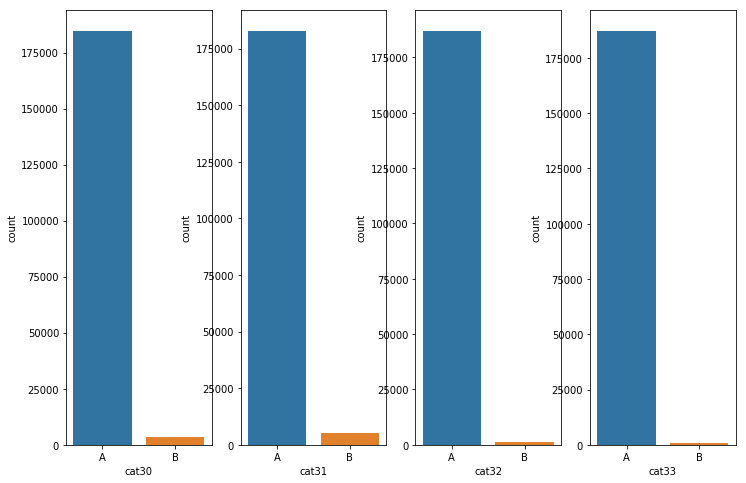

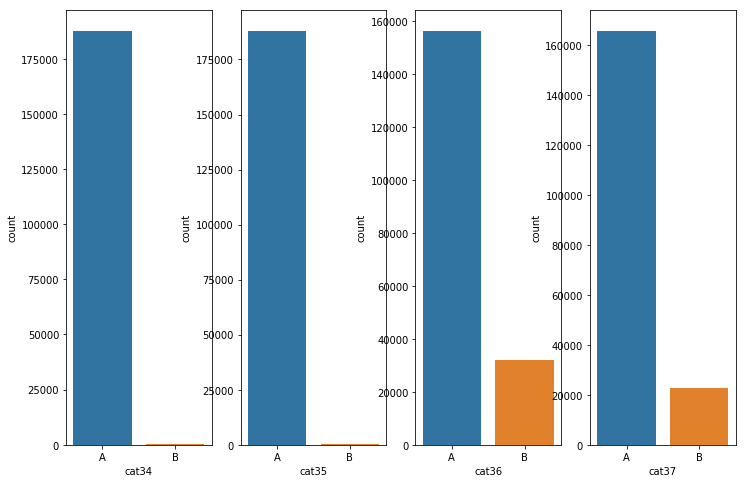

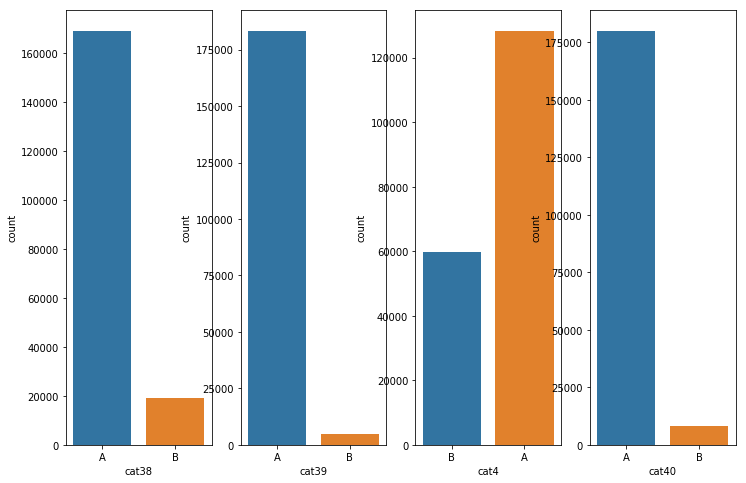

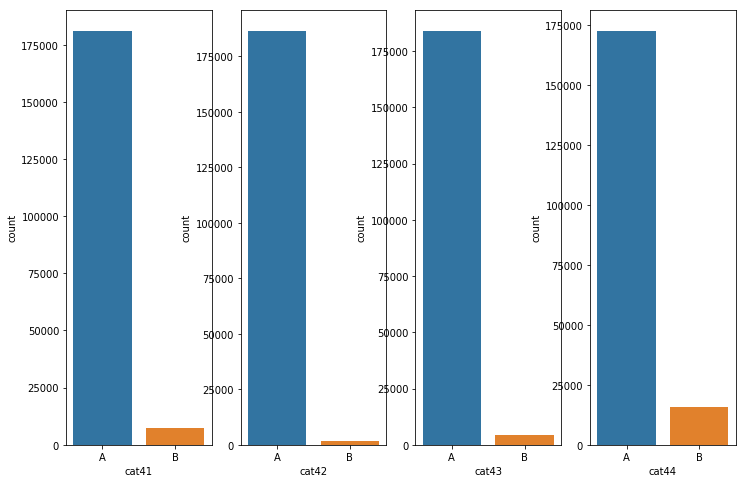

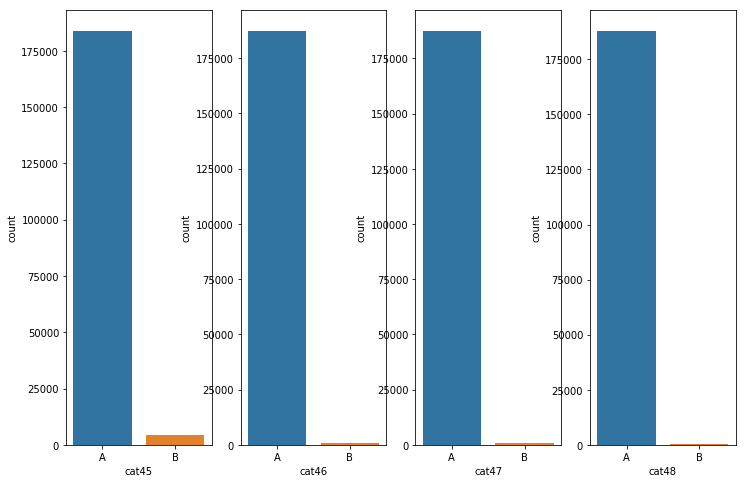

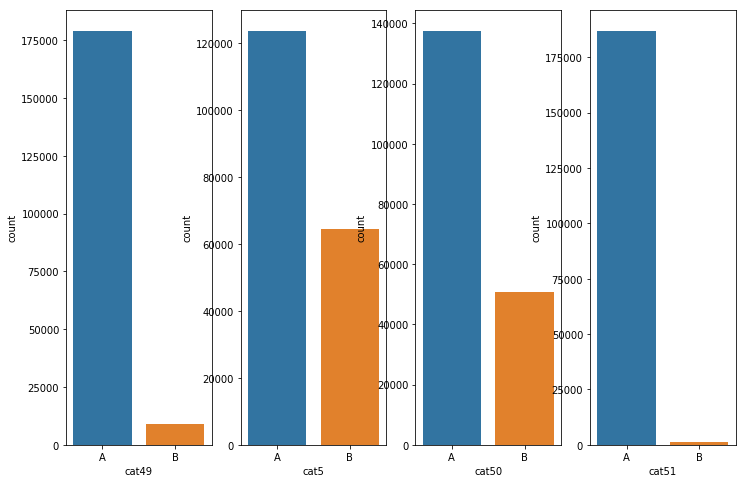

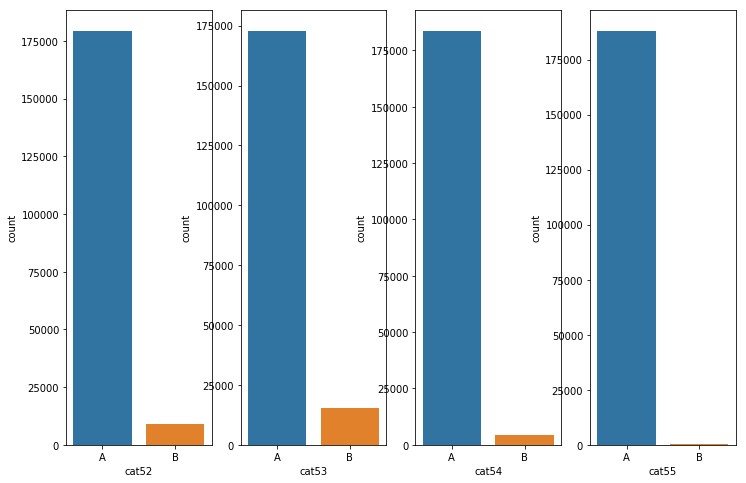

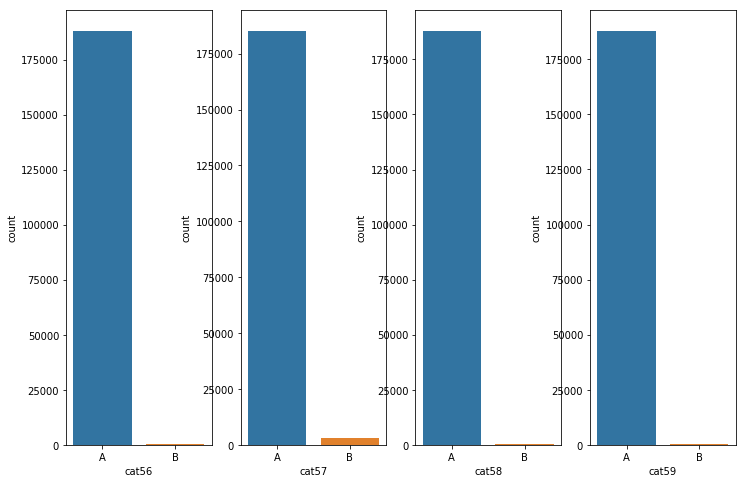

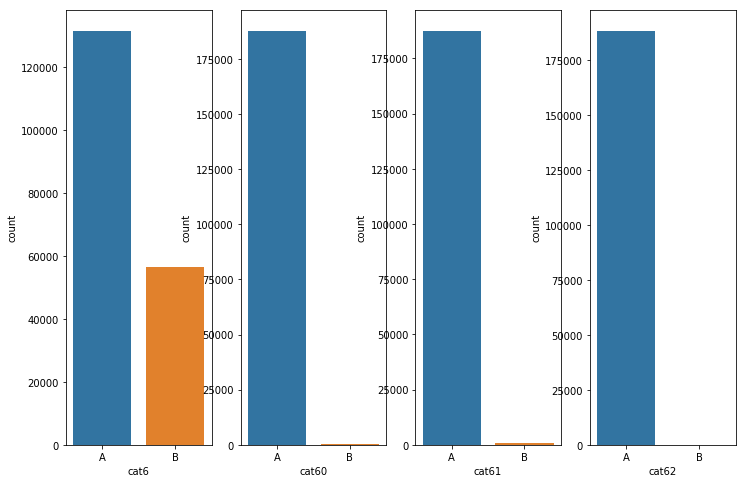

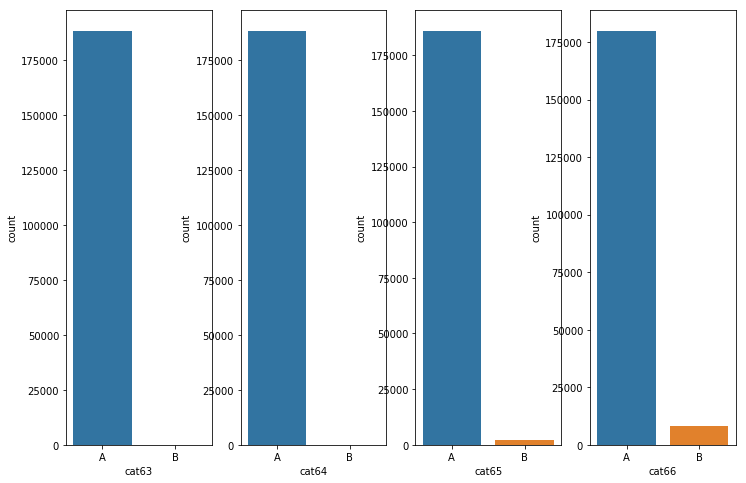

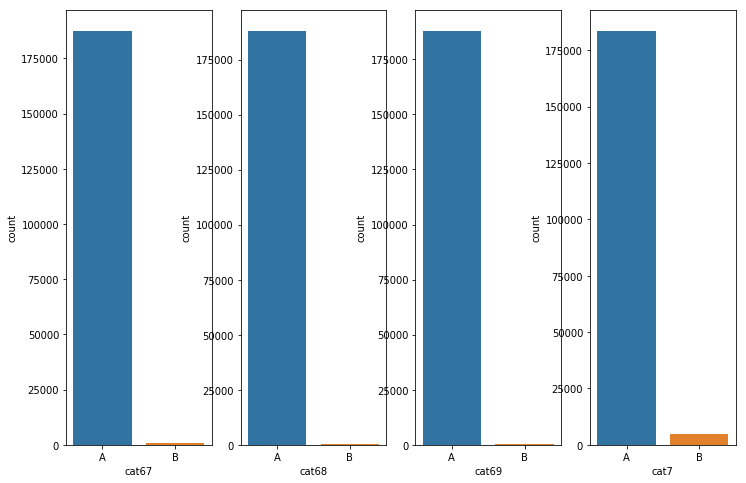

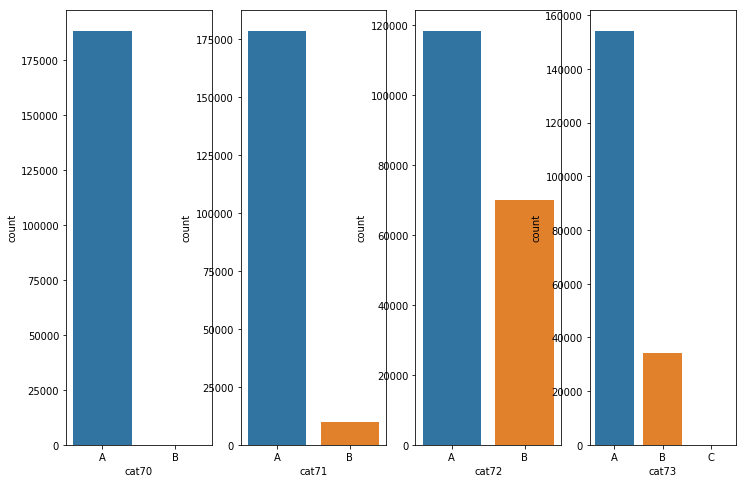

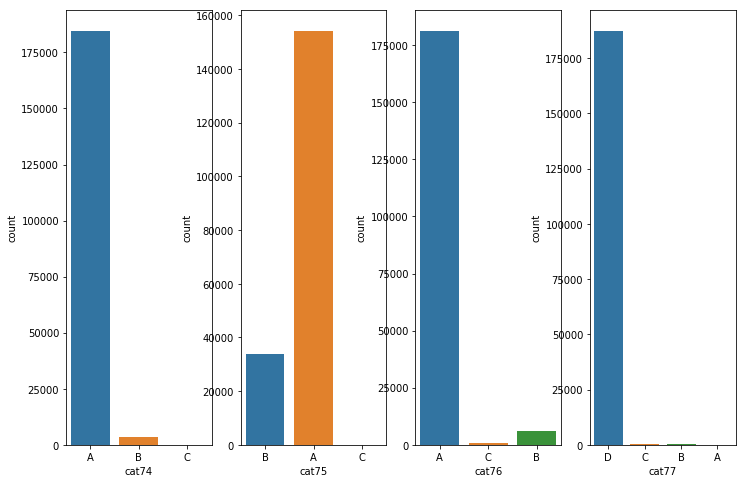

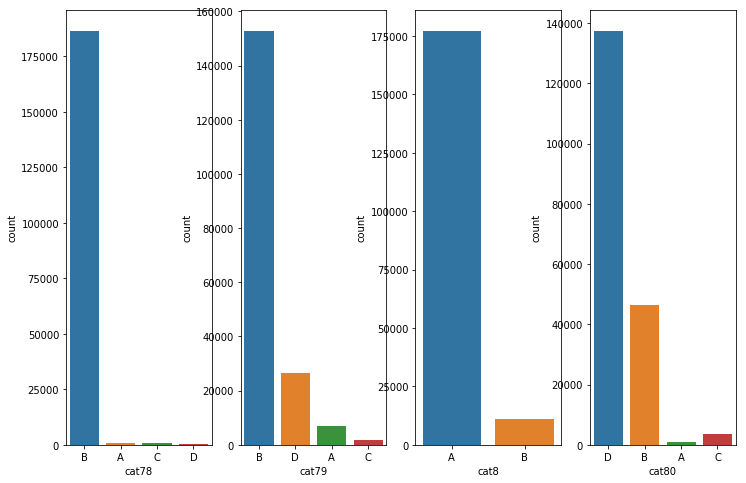

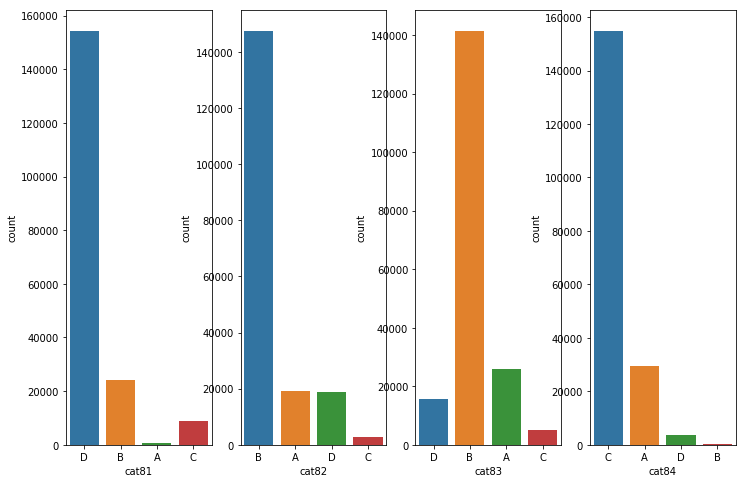

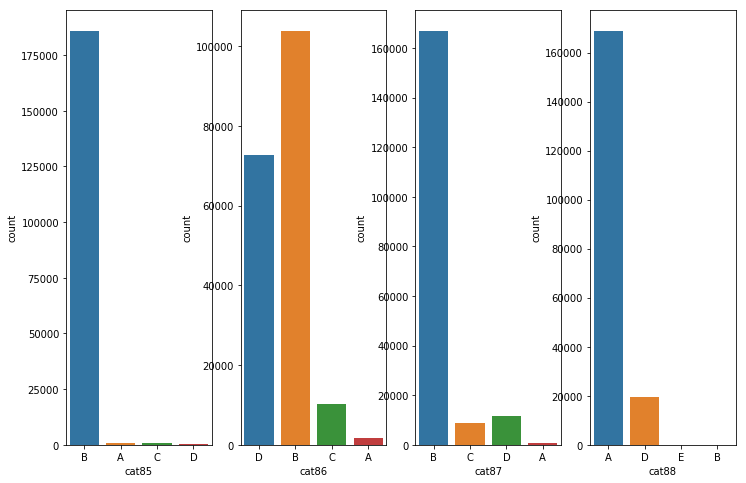

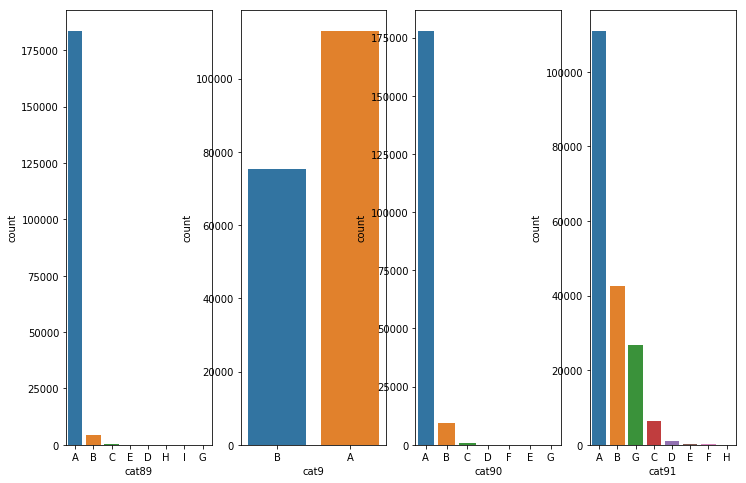

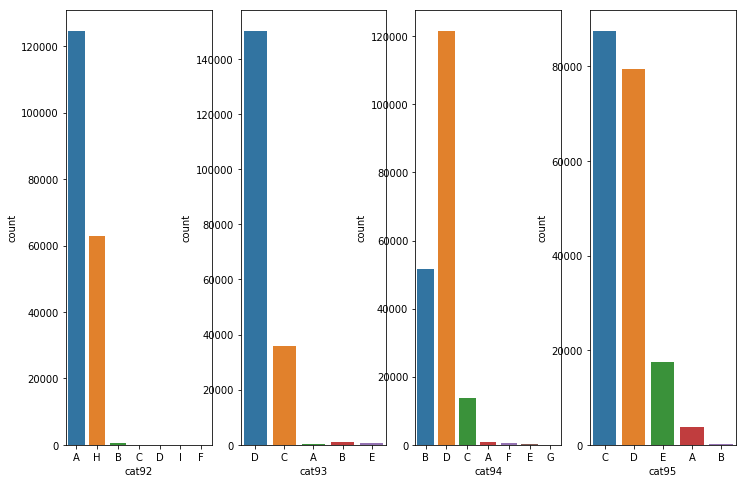

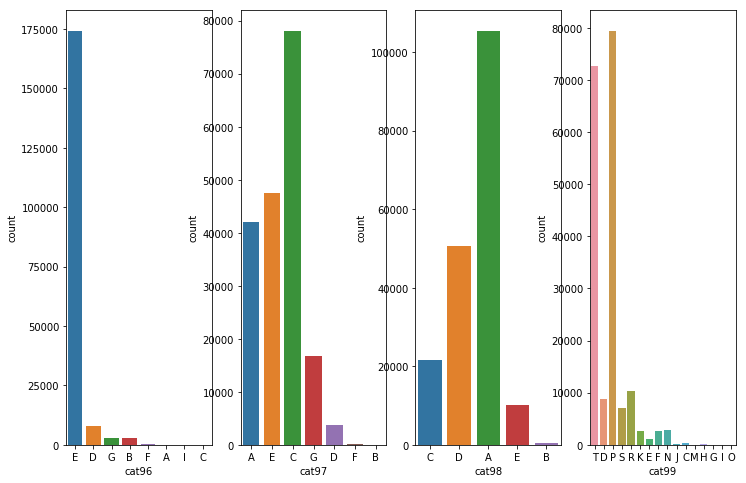

In [29]:
#Plot count plot for all attributes in a 29x4 grid
n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.countplot(x=cat_cols[i*n_cols+j], data=df_train, ax=ax[j])

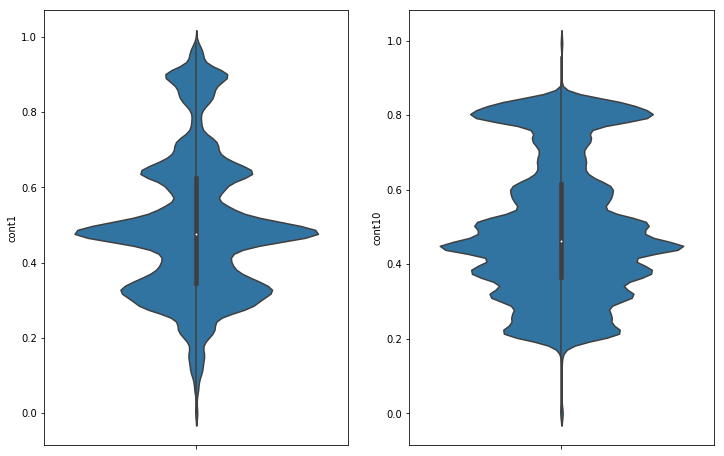

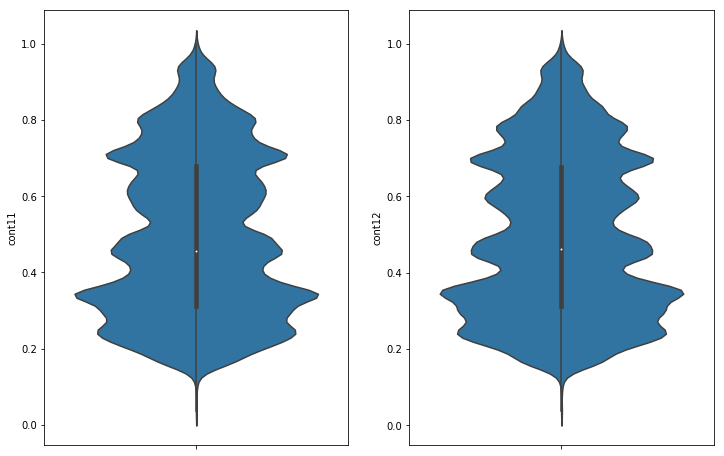

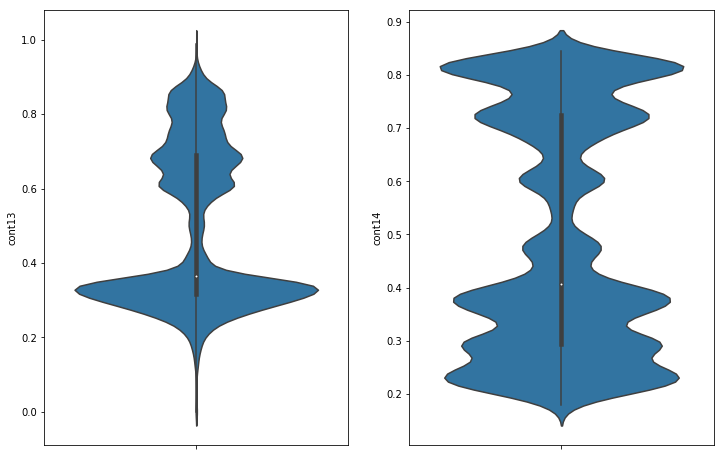

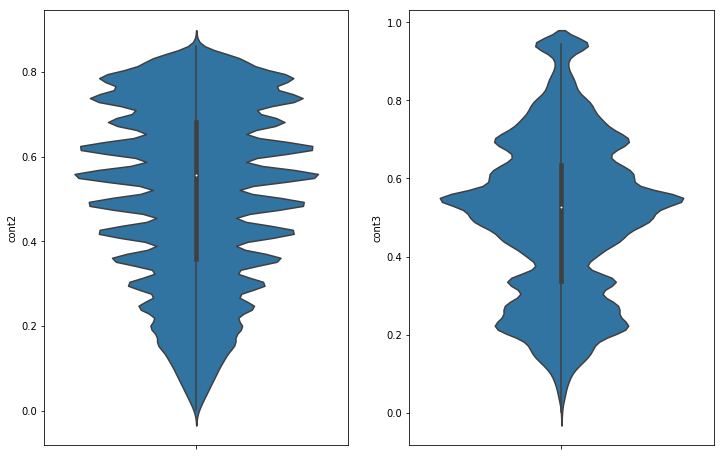

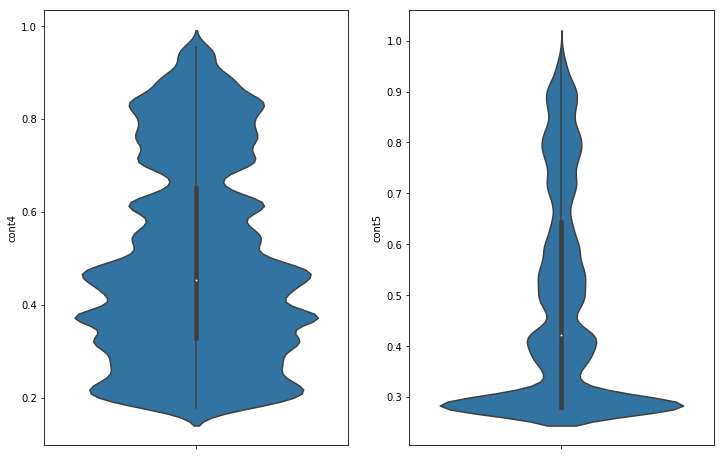

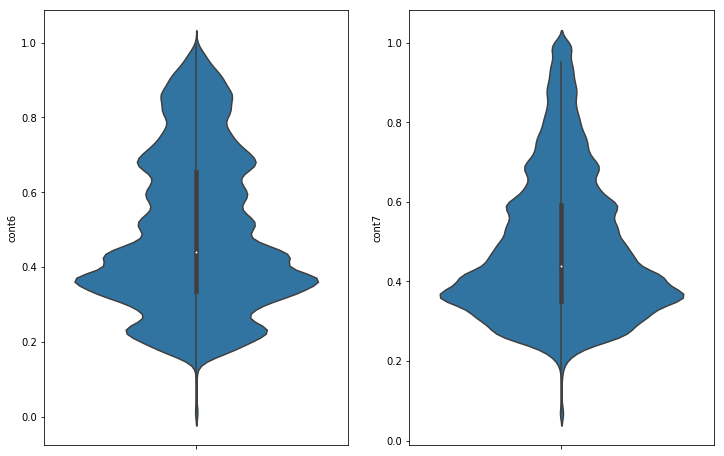

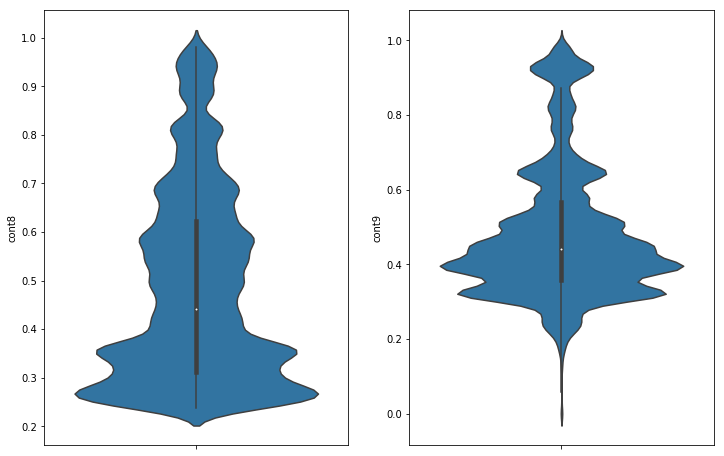

In [30]:
# Plot violin for all attributes in a 7x2 grid
# violin plot: a combination of box and density plots
n_cols = 2
n_rows = 7

for i in range(n_rows):
    fg,ax = plt.subplots(nrows=1,ncols=n_cols,figsize=(12, 8))
    for j in range(n_cols):
        sns.violinplot(y=cont_cols[i*n_cols+j], data=df_train, ax=ax[j])

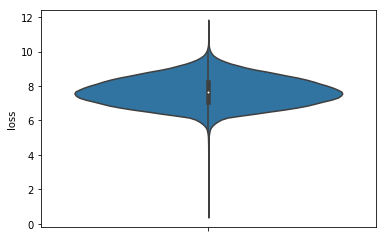

In [31]:
#log1p function applies log(1+x) to all elements of the column
loss = np.log1p(df_train["loss"])
sns.violinplot(data=df_train,y=loss)
plt.show()

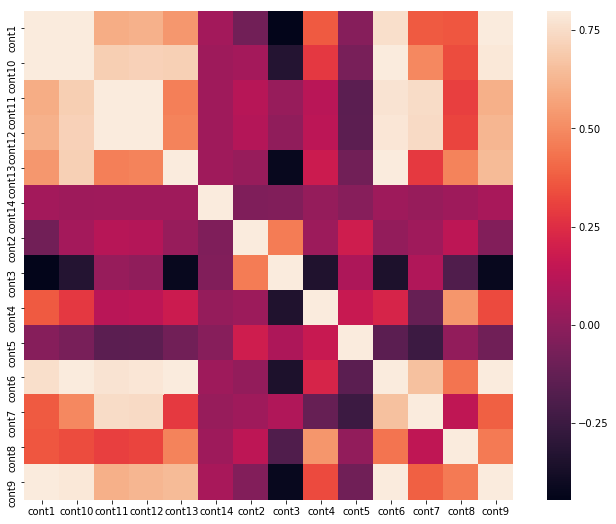

In [33]:
corrmat = df_train[cont_cols].corr()
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

## 3. transform categorical features

In [21]:
from sklearn import preprocessing

In [36]:
LBE = preprocessing.LabelEncoder()
start=time.time()
LE_map=dict()
for cat_col in cat_cols:
    full_data[cat_col] = LBE.fit_transform(full_data[cat_col])
    LE_map[cat_col]=dict(zip(LBE.classes_, LBE.transform(LBE.classes_)))
print ('Label enconding processes in %f seconds' % (time.time() - start))

Label enconding processes in 81.126716 seconds


In [37]:
OHE = preprocessing.OneHotEncoder(sparse=True)
start = time.time()
full_data_sparse = OHE.fit_transform(full_data[cat_cols])
print('One-Hot encoding processes in %f seconds' % (time.time() - start))

One-Hot encoding processes in 6.953342 seconds


In [38]:
print(full_data_sparse.shape)

(313864, 1176)


## 4. transform cont features

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b4c3208>,
      dtype=object)

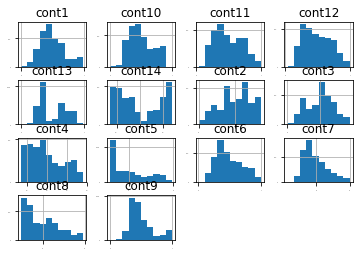

In [57]:
full_data[cont_cols].hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)

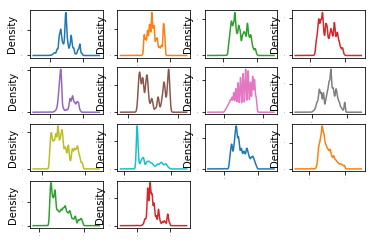

In [60]:
full_data[cont_cols].plot(kind= 'density', subplots=True, layout=(4,4), sharex=False, legend=False, fontsize=1)
plt.show()

In [39]:
from scipy.stats import skew, boxcox

In [40]:
full_data[cont_cols].isnull().sum()

cont1     0
cont10    0
cont11    0
cont12    0
cont13    0
cont14    0
cont2     0
cont3     0
cont4     0
cont5     0
cont6     0
cont7     0
cont8     0
cont9     0
dtype: int64

In [41]:
skewed_cols = full_data[cont_cols].apply(lambda x: skew(x))

In [43]:
skewed_cols

cont1     0.513205
cont10    0.352116
cont11    0.281139
cont12    0.291997
cont13    0.376138
cont14    0.250673
cont2    -0.311146
cont3    -0.007023
cont4     0.417559
cont5     0.679610
cont6     0.458413
cont7     0.825889
cont8     0.673237
cont9     1.067247
dtype: float64

In [44]:
skelist = list(skewed_cols[(skewed_cols > 0.25) | (skewed_cols < -0.25)].index)

In [45]:
for skewed in skelist:
    full_data[skewed], lam = boxcox(full_data[skewed] + 1)

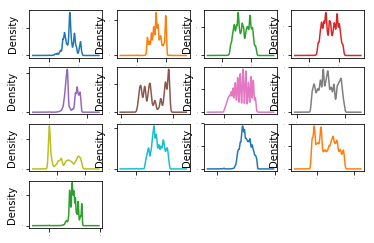

In [75]:
full_data[skelist].plot(kind= 'density', subplots=True, layout=(4,4), sharex=False, legend=False, fontsize=1)
plt.show()

In [46]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

In [47]:
full_data[cont_cols] = scaler.fit_transform(full_data[cont_cols])

In [48]:
train_size

188318

In [49]:
from scipy import sparse
full_data_sparse = sparse.hstack((full_data_sparse,full_data[cont_cols]), format='csr')
print (full_data_sparse.shape)

(313864, 1190)


In [50]:
shift = 200
full_cols = cat_cols + cont_cols
train_x = full_data_sparse[:train_size]
test_x = full_data_sparse[train_size:]
train_y = np.log(full_data[:train_size].loss.values + 200)
ID = full_data.id[:train_size].values

In [30]:
# shift = 200

# full_cols = cat_cols + cont_cols
# train_x = full_data[full_cols][:train_size].values
# test_x = full_data[full_cols][train_size:].values
# train_y = np.log(full_data[:train_size].loss.values + shift)
# ID = full_data.id[:train_size].values

In [31]:
# from sklearn.model_selection import train_test_split

In [32]:
# X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)##

## 5. gridresearch model

In [54]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [51]:
def logregobj(labels, preds):
    con = 2
    x =preds-labels
    grad =con*x / (np.abs(x)+con)
    hess =con**2 / (np.abs(x)+con)**2
    return grad, hess 

def log_mae(y,yhat):
    return mean_absolute_error(np.exp(y), np.exp(yhat))

log_mae_scorer = metrics.make_scorer(log_mae, greater_is_better = False)

In [55]:
def search_model(train_x, train_y, est, param_grid, n_jobs, cv, refit=False):
    ##Grid Search for the best model
    model = GridSearchCV(estimator  = est,
                                     param_grid = param_grid,
                                     scoring    = log_mae_scorer,
                                     verbose    = 10,
                                     n_jobs  = n_jobs,
                                     iid        = True,
                                     refit    = refit,
                                     cv      = cv)
    # Fit Grid Search Model
    model.fit(train_x, train_y)
    print("params:\n")
    print(model.cv_results_.__getitem__('params'))
    print("mean test scores:\n")
    print(model.cv_results_.__getitem__('mean_test_score'))
    print("std test scores:\n")
    print(model.cv_results_.__getitem__('std_test_score'))
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)
    print("Scores:", model.grid_scores_)
    print("**********************************************")
    
    return model

In [57]:
# time consuming, use gpu to tune
param_grid = {'objective':[logregobj],
              'learning_rate':[0.02, 0.04, 0.06, 0.08],
              'n_estimators':[1500],
              'max_depth': [9],
              'min_child_weight':[50],
              'subsample': [0.78],
              'colsample_bytree':[0.67],
              'gamma':[0.9],
              'nthread': [-1],
              'seed' : [1234]}

model = search_model(train_x,
                     train_y,
                     xgb.XGBRegressor(),
                     param_grid,
                     n_jobs = 1,
                     cv = 4,
                     refit = True)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] colsample_bytree=0.67, gamma=0.9, learning_rate=0.02, max_depth=9, min_child_weight=50, n_estimators=1500, nthread=-1, objective=<function logregobj at 0x1a16217f28>, seed=1234, subsample=0.78 


KeyboardInterrupt: 

In [59]:
# here just an example, please use the optimal parameters from last gridsearch cell
rgr = xgb.XGBRegressor(seed = 1234, 
                       learning_rate = 0.01, # smaller, better results, more time
                       n_estimators = 15, # Number of boosted trees to fit. 
                       max_depth=9, # the maximum depth of a tree
                       min_child_weight=50,
                       colsample_bytree=0.67, # the fraction of columns to be randomly samples for each tree
                       subsample=0.78, # the fraction of observations to be randomly samples for each tree
                       gamma=0.9, # Minimum loss reduction required to make a further partition on a leaf node of the tree, 
                       # the larger, the more conservative 
                       nthread = -1, # Number of parallel threads used to run xgboost.
                       silent = False # Whether to print messages while running boosting.
                      )
rgr.fit(train_x, train_y)

[20:53:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 2 pruned nodes, max_depth=9
[20:53:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[20:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 82 extra nodes, 0 pruned nodes, max_depth=9
[20:53:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 4 pruned nodes, max_depth=9
[20:53:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 76 extra nodes, 2 pruned nodes, max_depth=9
[20:53:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 84 extra nodes, 0 pruned nodes, max_depth=9
[20:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 94 extra nodes, 0 pruned nodes, max_depth=9
[20:53:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 88 extra nodes, 2 pruned nodes, max_depth=9
[20:53:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 102 extra nodes, 0 pruned nodes, max

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.67, gamma=0.9, learning_rate=0.01,
       max_delta_step=0, max_depth=9, min_child_weight=50, missing=None,
       n_estimators=15, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=1234, silent=False, subsample=0.78)

In [61]:
pred_y = np.exp(rgr.predict(test_x)) - 200

results = pd.DataFrame()
results['id'] = full_data[train_size:].id
results['loss'] = pred_y
results.to_csv("./sub.csv", index=False)
print ("Submission created.")

Submission created.


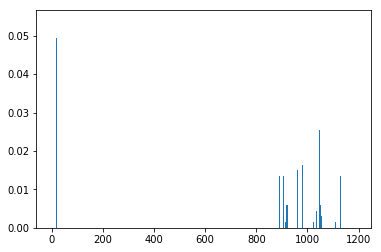

In [62]:
plt.bar(range(len(rgr.feature_importances_)), rgr.feature_importances_)
plt.show()

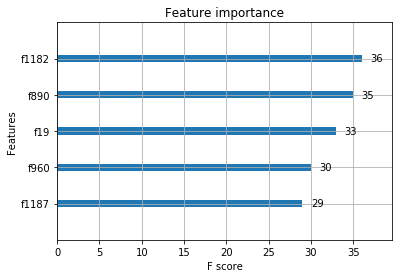

In [63]:
xgb.plot_importance(rgr,max_num_features=5,importance_type='weight')

In [64]:
np.argsort(rgr.feature_importances_)

array([ 594,  742,  743, ...,   19,  890, 1182])